In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from data import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

## Загрузим данные

In [3]:
X, y = load_pkl('stats/X.pkl'), load_pkl('stats/y.pkl')

In [4]:
X['para'] = load_pkl('stats/para.pkl')

In [5]:
X['topp'] = [int(18 <= para_ind <= 23) for para_ind in X.para]

In [6]:
y = y[X.topp < 1]
X = X[X.topp < 1]

In [7]:
print(f'Размер датасета: {len(X)}')

Размер датасета: 199


In [8]:
X = X.drop(['topp', 'para'], axis=1)

In [9]:
X.head()

,bleu,rouge-l,wmd,pos,rouge-1,rouge-2,Levenshtein similarity,Additions proportion,Deletions proportion
0,48.762546,0.734177,1.067048,3.102178,0.756098,0.550000,0.848352,0.227273,0.295455
1,47.346550,0.607595,1.055076,3.102178,0.780488,0.575000,0.631579,0.250000,0.340909
2,49.978468,0.650000,0.747549,3.102178,0.829268,0.625000,0.639130,0.227273,0.295455
4,56.111216,0.750000,0.800583,3.006511,0.800000,0.714286,0.810000,0.277778,0.166667
5,80.650086,0.866667,0.403395,0.000000,0.866667,0.857143,0.899471,0.125000,0.125000


In [10]:
X.describe()

,bleu,rouge-l,wmd,pos,rouge-1,rouge-2,Levenshtein similarity,Additions proportion,Deletions proportion
count,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000
mean,50.945534,0.763147,0.666727,0.687342,0.798013,0.630711,0.843565,0.188180,0.213026
std,23.788701,0.139507,0.467887,1.221732,0.131163,0.193770,0.102335,0.116735,0.129217
min,0.000000,0.333333,0.000000,0.000000,0.400000,0.000000,0.533333,0.000000,0.000000
25%,38.638457,0.666667,0.330474,0.000000,0.714286,0.500000,0.783350,0.105263,0.116516
50%,50.957115,0.789474,0.585016,0.000000,0.827586,0.625000,0.860215,0.166667,0.200000
75%,66.773448,0.870833,0.938782,1.099617,0.892857,0.760000,0.914507,0.250000,0.312500
max,100.000000,1.000000,1.968615,6.214542,1.000000,1.000000,1.000000,0.666667,0.535714


In [11]:
y = y.astype(int)

## Поделим на Train / Test

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=213123, shuffle=True, stratify=y)

In [13]:
len(X_train), len(X_test)

(149, 50)

## Вспомогательная функция для Grid Search и вывода результатов

In [14]:
def regression(pipe, params):
    grid = GridSearchCV(pipe, params, cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)
    
    y_pred = grid.predict(X_test)
    print(f'Лучшие параметры: {grid.best_params_}')
    print(f'RMSE:{np.sqrt(mean_squared_error(y_test, y_pred))}, R2:{r2_score(y_test, y_pred)}, MAE:{mean_absolute_error(y_test, y_pred)}')
    
    df1 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    df1.plot(kind='bar',figsize=(25,5)).legend(bbox_to_anchor=(1.2, 0.5))
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    plt.show()
    
    return grid

## Ridge

In [15]:
from sklearn.linear_model import Ridge

Лучшие параметры: {'ridge__alpha': 1}
RMSE:1.3517831403895417, R2:0.15791812965833574, MAE:0.9612858834392337


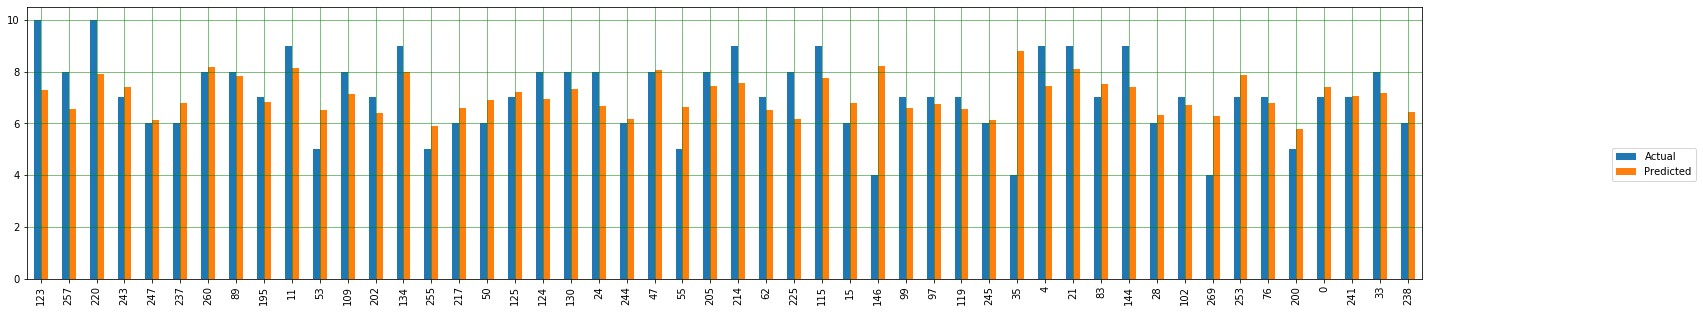

In [16]:
ridge = regression(Pipeline([('scaler', MinMaxScaler()), ('ridge', Ridge())]), {'ridge__alpha': [0, 1e-3, 1e-2, 1e-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]})

In [17]:
for val, col in sorted(zip(ridge.best_estimator_[-1].coef_, X.columns), key=lambda x: abs(x[0]), reverse=True):
    print(f'{col}:{val},')

Levenshtein similarity:-1.9760072371790085,
rouge-1:-1.11097497221801,
rouge-2:-0.9488513961113775,
Deletions proportion:-0.6443701072331897,
pos:0.596178903348235,
rouge-l:-0.5685522917002621,
Additions proportion:-0.34457519235657647,
bleu:0.1322399660896214,
wmd:-0.03232817260038826,


## Обычная регрессия

In [18]:
from sklearn.linear_model import LinearRegression

Лучшие параметры: {}
RMSE:1.3493055175604318, R2:0.16100212916173962, MAE:0.9135539476235484


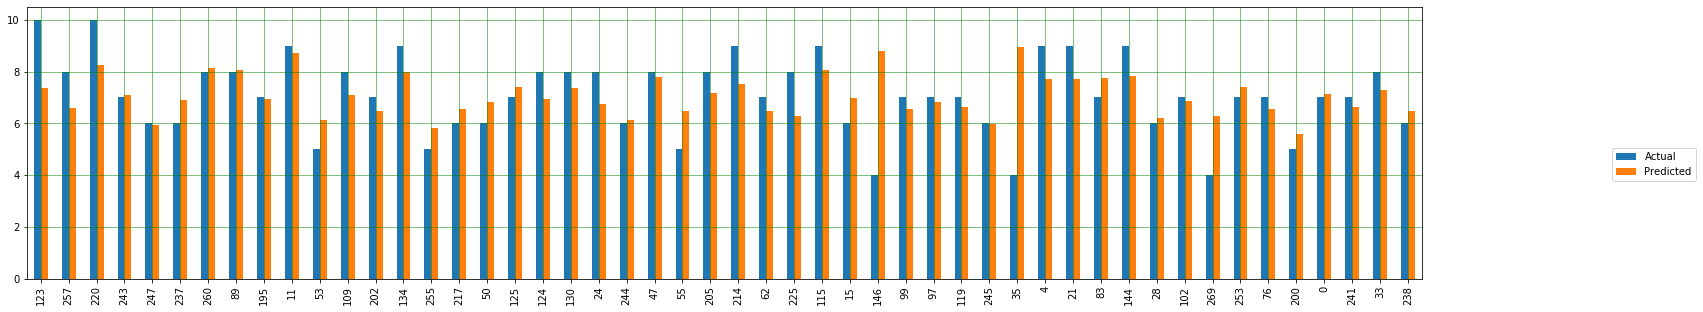

In [19]:
reg = regression(Pipeline([('scaler', MinMaxScaler()),('linear', LinearRegression())]), {})

In [20]:
for val, col in sorted(zip(reg.best_estimator_[-1].coef_, X.columns), key=lambda x: abs(x[0]), reverse=True):
    print(f'{col}:{val},')

Levenshtein similarity:-4.787022582406884,
rouge-1:-3.591965989663905,
rouge-l:3.2638586401020473,
Deletions proportion:-2.3340014908088498,
rouge-2:-2.26105876933585,
wmd:-0.8271771473970148,
Additions proportion:0.7459045505637258,
pos:0.6591465175724949,
bleu:0.49654638762621484,


## Lasso

In [21]:
from sklearn.linear_model import Lasso

Лучшие параметры: {'lasso__alpha': 0.001}
RMSE:1.351562198023004, R2:0.1581933755185373, MAE:0.9278467216684553


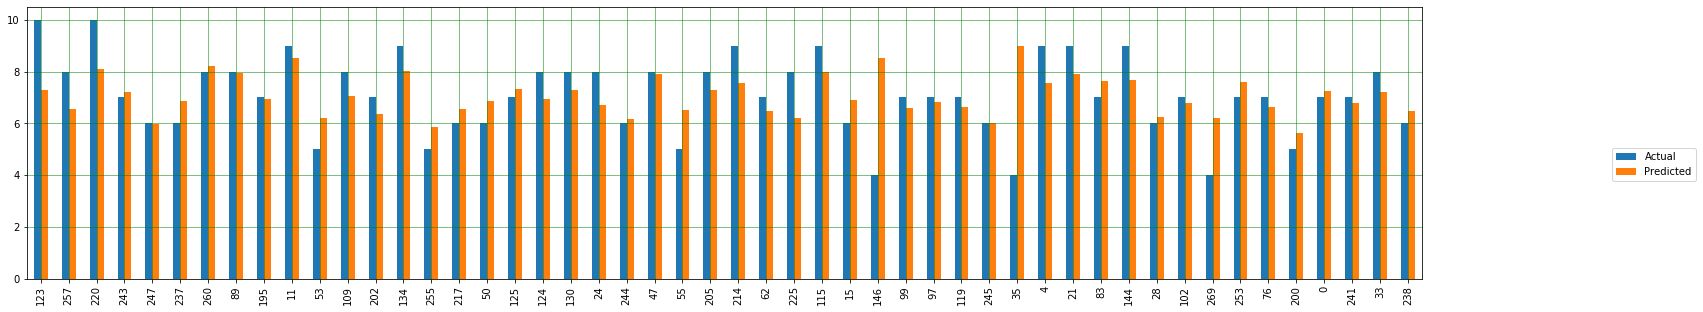

In [22]:
lasso = regression(Pipeline([('lasso', Lasso())]), {'lasso__alpha': [1e-3, 1e-2, 1e-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]})

In [23]:
for val, col in sorted(zip(lasso.best_estimator_[-1].coef_, X.columns), key=lambda x: abs(x[0]), reverse=True):
    print(f'{col}:{val},')

Levenshtein similarity:-7.519239720958897,
rouge-1:-4.11541792703436,
Deletions proportion:-3.0307014782982074,
rouge-l:1.9271282850895592,
rouge-2:-1.7729637810081567,
wmd:-0.2803710013184158,
pos:0.11012453905190635,
Additions proportion:0.037578094348237584,
bleu:0.0038566819689753585,


## Деревья

In [24]:
from sklearn.tree import DecisionTreeRegressor

Лучшие параметры: {'tree__max_depth': 1}
RMSE:1.3056412911681659, R2:0.21442434045932013, MAE:0.9554716981132075


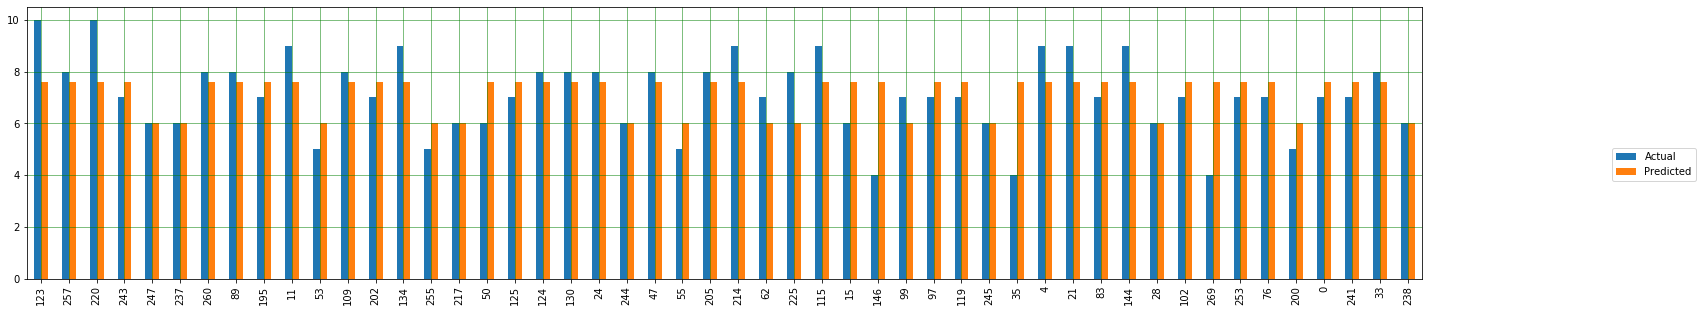

In [25]:
tree = regression(Pipeline([('tree', DecisionTreeRegressor())]), {'tree__max_depth': range(1, 10)})

In [26]:
for val, col in sorted(zip(tree.best_estimator_[-1].feature_importances_, X.columns), key=lambda x: abs(x[0]), reverse=True):
    print(f'{col}:{val},')

Levenshtein similarity:1.0,
bleu:0.0,
rouge-l:0.0,
wmd:0.0,
pos:0.0,
rouge-1:0.0,
rouge-2:0.0,
Additions proportion:0.0,
Deletions proportion:0.0,


## Лес

In [27]:
from sklearn.ensemble import RandomForestRegressor

RMSE:1.1877438883929865, R2:0.3498914541866861, MAE:0.7858545352401474


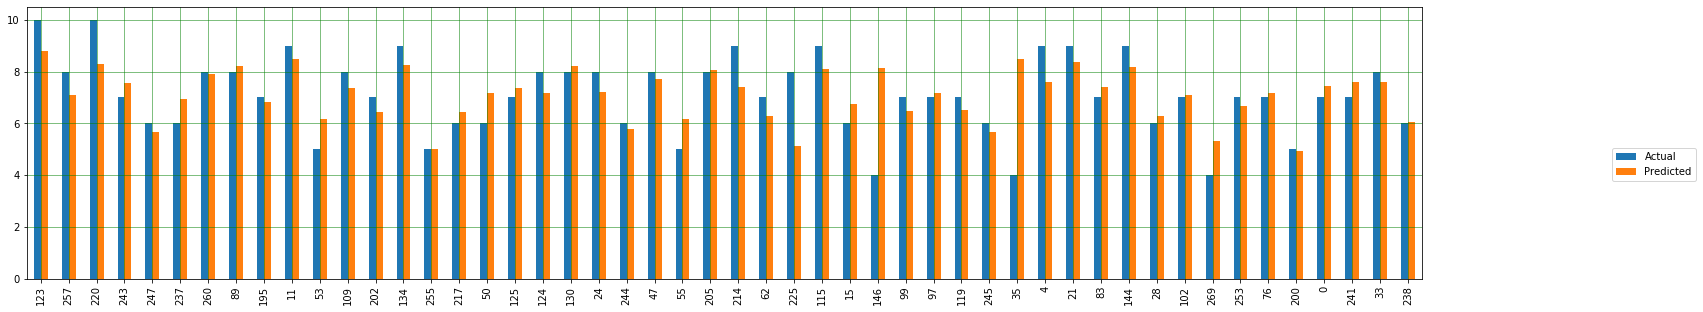

Levenshtein similarity:0.29679041776599957,
rouge-2:0.2036914139238062,
rouge-l:0.1749589280711512,
Additions proportion:0.08062655770083506,
rouge-1:0.05895319638247184,
Deletions proportion:0.05670147948913054,
wmd:0.05353074171422039,
bleu:0.03948163261598587,
pos:0.03526563233639919,


In [28]:
forest = RandomForestRegressor(max_depth=7, n_estimators=100)
forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)
print(f'RMSE:{np.sqrt(mean_squared_error(y_test, y_pred))}, R2:{r2_score(y_test, y_pred)}, MAE:{mean_absolute_error(y_test, y_pred)}')

df1 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1.plot(kind='bar',figsize=(25,5)).legend(bbox_to_anchor=(1.2, 0.5))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

for val, col in sorted(zip(forest.feature_importances_, X.columns), key=lambda x: abs(x[0]), reverse=True):
    print(f'{col}:{val},')

In [29]:
# save_pkl(forest, 'regression_forest_maxdepth_7_rsq_35_mae_076_tree_100.pkl')

## SVR

In [30]:
from sklearn.svm import SVR

In [31]:
param_grid = [
  {'svm__C': [0, 1, 10, 100], 'svm__gamma': [1e-2, 1e-1, 0, 1, 'auto'], 'svm__kernel': ['rbf']},
  {'svm__C': [0, 1, 10, 100], 'svm__gamma': [1e-2, 1e-1, 0, 1, 'auto'], 'svm__kernel': ['poly'], 'svm__degree':[2, 3, 4, 5, 6, 7]}
 ]

Лучшие параметры: {'svm__C': 1, 'svm__gamma': 1, 'svm__kernel': 'rbf'}
RMSE:1.3056726544718753, R2:0.21438659878542232, MAE:0.8729921447741918


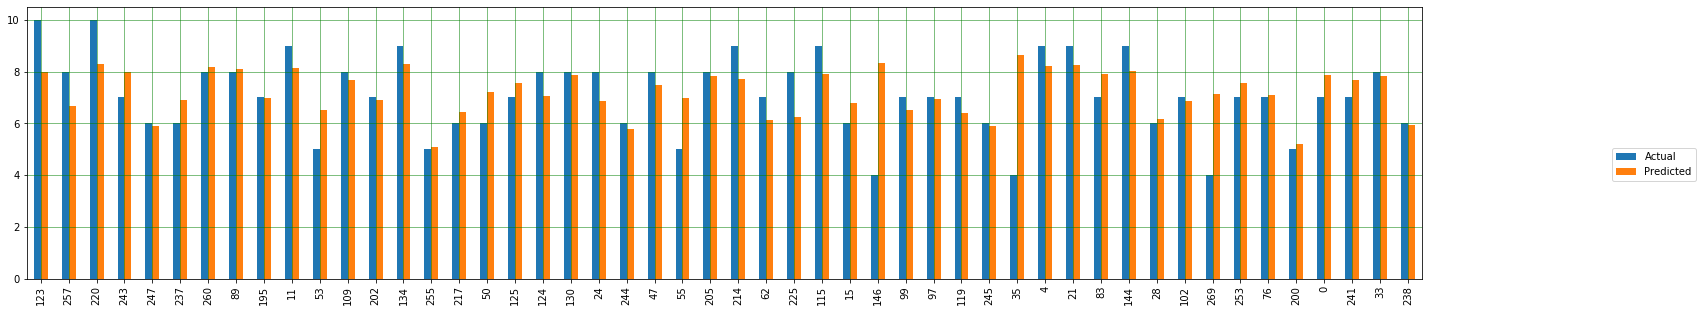

In [32]:
svm = regression(Pipeline([('scaler', MinMaxScaler()), ('svm', SVR())]), param_grid)